In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import Gate
from qiskit.visualization import plot_histogram

In [2]:
class Oracle(Gate):
    def __init__(self, s):
        super().__init__('Oracle', len(s)+1, [])
        self.s = s
        self.n = len(s)

    def _define(self):
        qc = QuantumCircuit(self.num_qubits, name=self.name)
        s = self.s
        n = self.n

        for i in range(n):
            if s[i] == 1:
                qc.cx(i, n)
        
        self.definition = qc

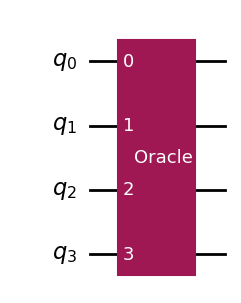

In [3]:
s = np.random.randint(2, size=3)
oracle_gate = Oracle(s)
qc = QuantumCircuit(4)
qc.append(oracle_gate, range(4))
qc.draw('mpl', style='iqx')

In [4]:
def oracle_test(oracle, basis):
    n = oracle.n
    qc = QuantumCircuit(n+1, 1)
    initial_state = np.array(basis) / np.linalg.norm(basis)
    qc.initialize(initial_state, reversed(range(n)))
    qc.barrier()
    qc.append(oracle, qc.qubits)
    qc.measure(n, 0)
    return qc

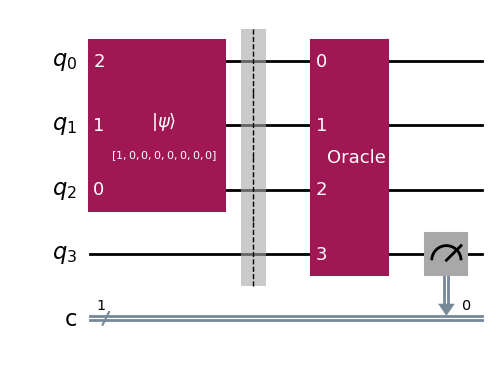

In [5]:
qc = oracle_test(oracle_gate, [1, 0, 0, 0, 0, 0, 0, 0])
qc.draw('mpl', style='iqx')

In [6]:
def convert_zbasis_to_cbasis(zbasis):
    """
    Converts a basis state in the Z basis to the computational basis
    
    Example:
        Input: [0,0] -> Output: [1,0,0,0]
        Input: [0,1] -> Output: [0,1,0,0]
        Input: [1,0] -> Output: [0,0,1,0]
        Input: [1,1] -> Output: [0,0,0,1]
    """
    n = 2**len(zbasis)
    
    # z basis to binary number
    bin_str = "".join([str(x) for x in zbasis])
    num = int(bin_str,2)

    # binary number to computational basis
    cbasis = np.zeros(n)
    cbasis[num] = 1

    return cbasis

In [7]:
simulator = Aer.get_backend('qasm_simulator')

states = np.eye(3, dtype=int)
bases = []
for i in range(states.shape[0]):
    bases.append(convert_zbasis_to_cbasis(states[i]))

strings = []
for basis in bases:
    qc = oracle_test(oracle_gate, basis)
    result = execute(qc, simulator, shots=1000).result()
    counts = result.get_counts(qc)
    # Pick max count
    string = max(counts, key=counts.get)
    strings.append(int(string))

In [8]:
strings

[1, 1, 0]

In [9]:
np.array_equal(s, strings)

True

In [10]:
class Oracle(Gate):
    def __init__(self, n):
        super().__init__('Oracle', n+1, [])
        self.n = n
        self.s = np.random.randint(2, size=n)

    def _define(self):
        qc = QuantumCircuit(self.num_qubits, name=self.name)
        n = self.n

        for i in range(n):
            if self.s[i] == 1:
                qc.cx(i, n)
        
        self.definition = qc

In [11]:
def bernstein_vazirani(oracle):
    n = oracle.n
    qc = QuantumCircuit(n+1, n)
    # Make sure qubit n is in state |->
    qc.x(n)
    qc.h(n)
    qc.barrier()

    # Apply Hadamard gates before querying the oracle
    for i in range(n):
        qc.h(i)
    qc.barrier()

    # Query the oracle
    qc.append(oracle, qc.qubits)

    # Apply Hadamard gates after querying the oracle
    qc.h(range(n))

    # Measure all qubits
    qc.measure(range(n), reversed(range(n)))
    return qc

In [12]:
def run_bv(n):
    oracle_gate = Oracle(n)
    qc = bernstein_vazirani(oracle_gate)
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, shots=1000).result()
    counts = result.get_counts(qc)
    return counts, oracle_gate.s

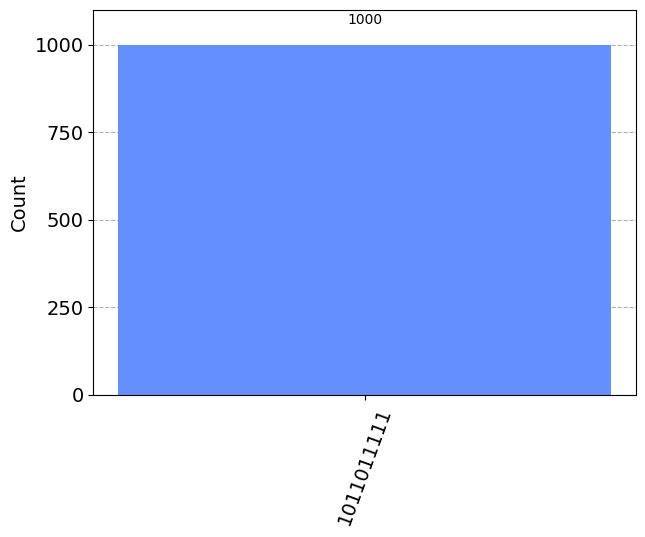

In [13]:
counts, s = run_bv(10)
plot_histogram(counts)

In [14]:
s

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1])